# Code to read data with feature view from Hopsworks, trains a model to predict wine quality and uploads the model to Hopsworks

In [1]:
import hopsworks
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from matplotlib import pyplot
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import joblib
import os

/Users/gardaasness/anaconda3/envs/scalableML/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Log in to Hopsworks and get feature store
project = hopsworks.login()
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/193689
Connected. Call `.close()` to terminate connection gracefully.


In [4]:
# Extract the feature view from Hopsworks, which is the input set of features to the model
wine_fg = fs.get_feature_group(name="wine", version=1)
query = wine_fg.select_all()
feature_view = fs.get_or_create_feature_view(
    name="wine", 
    version=1,
    description="Read from Wine dataset",
    labels=["quality"],
    query=query
)

Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/193689/fs/193608/fv/wine/version/1


In [5]:
# Randomly split the training data into train/test sets of features X and labels y (test size -> 0.2=20%)
X_train, X_test, y_train, y_test = feature_view.train_test_split(0.2)

# Train the model with the K-nearest-neighbor algorithm (Scikit-learn) using our features (X_train) and labels (y_train)
model = KNeighborsClassifier(n_neighbors=2)
model.fit(X_train, y_train.values.ravel())

Finished: Reading data from Hopsworks, using ArrowFlight (1.57s) 


KNeighborsClassifier(n_neighbors=2)

In [12]:
X_train

,type,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol
0,0,7.5,0.170,0.71,11.8,0.038,52.0,148.0,0.99801,3.03,0.46,8.9
1,1,8.5,0.655,0.49,6.1,0.122,34.0,151.0,1.00100,3.31,1.14,9.3
3,0,7.2,0.230,0.39,14.2,0.058,49.0,192.0,0.99790,2.98,0.48,9.0
5,1,7.5,0.580,0.03,4.1,0.080,27.0,46.0,0.99592,3.02,0.47,9.2
6,0,6.2,0.280,0.45,7.5,0.045,46.0,203.0,0.99573,3.26,0.46,9.2
...,...,...,...,...,...,...,...,...,...,...,...,...
5324,0,7.1,0.260,0.37,5.5,0.025,31.0,105.0,0.99082,3.06,0.33,12.6
5325,0,6.4,0.230,0.35,10.3,0.042,54.0,140.0,0.99670,3.23,0.47,9.2
5326,0,6.8,0.340,0.44,6.6,0.052,28.0,156.0,0.99550,3.14,0.41,9.6
5327,1,12.2,0.480,0.54,2.6,0.085,19.0,64.0,1.00000,3.10,0.61,10.5


In [16]:
y_train

,quality
0,5
1,5
3,7
5,5
6,6
...,...
5324,8
5325,5
5326,5
5327,6


In [15]:
# As you can see, ca. 80% (4263/5328 rows) of the data is training data
X_train.count()

type                    4263
fixed_acidity           4263
volatile_acidity        4263
citric_acid             4263
residual_sugar          4263
chlorides               4263
free_sulfur_dioxide     4263
total_sulfur_dioxide    4263
density                 4263
ph                      4263
sulphates               4263
alcohol                 4263
dtype: int64

In [17]:
# As you can see, ca. 20% (1066/5328 rows) of the data is test data
X_test.count()


type                    1066
fixed_acidity           1066
volatile_acidity        1066
citric_acid             1066
residual_sugar          1066
chlorides               1066
free_sulfur_dioxide     1066
total_sulfur_dioxide    1066
density                 1066
ph                      1066
sulphates               1066
alcohol                 1066
dtype: int64

In [23]:
# Evaluate the model performance using features from test set (X_test)
y_pred = model.predict(X_test)

# Compare predictions made by the model (y_pred) with the labels in the test set (y_test)
metrics = classification_report(y_test, y_pred, output_dict=True)
results = confusion_matrix(y_test, y_pred)

# Print the metrics 
for metric in metrics:
    print(metric, metrics[metric])

3 {'precision': 0.1111111111111111, 'recall': 0.2, 'f1-score': 0.14285714285714285, 'support': 5}
4 {'precision': 0.08196721311475409, 'recall': 0.10869565217391304, 'f1-score': 0.09345794392523364, 'support': 46}
5 {'precision': 0.4272030651340996, 'recall': 0.6299435028248588, 'f1-score': 0.5091324200913241, 'support': 354}
6 {'precision': 0.457002457002457, 'recall': 0.40700218818380746, 'f1-score': 0.43055555555555564, 'support': 457}
7 {'precision': 0.29850746268656714, 'recall': 0.11428571428571428, 'f1-score': 0.1652892561983471, 'support': 175}
8 {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 28}
9 {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1}
accuracy 0.4080675422138837
macro avg {'precision': 0.196541615578427, 'recall': 0.20856100820975623, 'f1-score': 0.19161318837537186, 'support': 1066}
weighted avg {'precision': 0.3908488379329996, 'recall': 0.4080675422138837, 'f1-score': 0.38549318627652424, 'support': 1066}


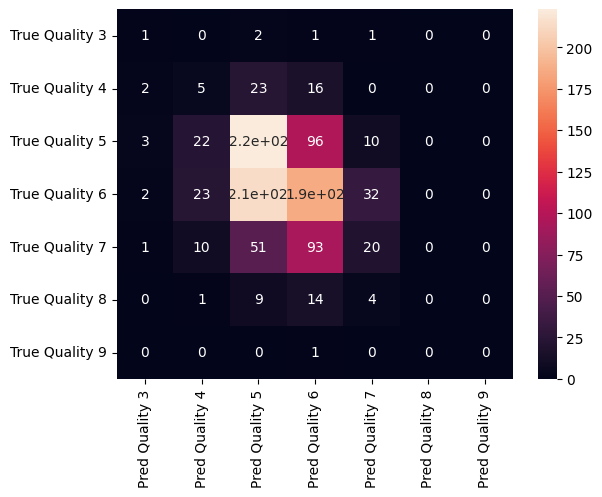

In [24]:
# Create confusion matric that shows true values vs predicted values
df_cm = pd.DataFrame(results, 
                     ["True Quality 3", "True Quality 4", "True Quality 5", "True Quality 6", "True Quality 7", "True Quality 8", "True Quality 9"],
                     ["Pred Quality 3", "Pred Quality 4", "Pred Quality 5", "Pred Quality 6", "Pred Quality 7", "Pred Quality 8", "Pred Quality 9"]
                    )

cm = sns.heatmap(df_cm, annot=True)
fig = cm.get_figure()

In [25]:
# Get an object for model registry from Hopsworks
mr = project.get_model_registry()

# Create folder to store wine model if it does not exist
model_dir = "wine_model"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)

# Save model and conusfion matrix to the correct folder. Both will be uploaded to model registry in Hopsworks
joblib.dump(model, model_dir + "/wine_model.pkl")
fig.savefig(model_dir + "/confusion_matrix.png")

# Specify schema of the model 
input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

# Create model in the model registry that includes the model name, metrics, schema and description
wine_model = mr.python.create_model(
    name="wine_model",
    metrics={"accuray:" : metrics["accuracy"]},
    model_schema=model_schema,
    description="Wine Quality Predictor"
)

# Upload model to modle registry with all files in the folder
wine_model.save(model_dir)


Connected. Call `.close()` to terminate connection gracefully.


Uploading: 100.000%|██████████| 34295/34295 elapsed<00:01 remaining<00:001,  3.05it/s]
Uploading: 100.000%|██████████| 945830/945830 elapsed<00:02 remaining<00:00  3.05it/s]
Uploading: 100.000%|██████████| 1066/1066 elapsed<00:01 remaining<00:000:09,  2.43s/it]
Model export complete: 100%|██████████| 6/6 [00:11<00:00,  1.98s/it]                   

Model created, explore it at https://c.app.hopsworks.ai:443/p/193689/models/wine_model/1


Model(name: 'wine_model', version: 1)